# Book Recommendation System

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import joblib

In [21]:
def load_data():
    books = pd.read_csv('/content/Books.csv')
    users = pd.read_csv('/content/Users.csv')
    ratings = pd.read_csv('/content/Ratings.csv')
    return books, users, ratings

In [22]:
def clean_data(ratings, books, users):
    # Drop rows with missing essential columns
    ratings = ratings.dropna(subset=['User-ID', 'ISBN', 'Book-Rating'])
    books = books.dropna(subset=['ISBN', 'Book-Title'])
    users = users.dropna(subset=['User-ID'])
    return ratings, books, users

In [23]:
def check_missing_values(books, users, ratings):
    print("Missing values in books dataset:")
    print(books.isnull().sum())

    print("\nMissing values in users dataset:")
    print(users.isnull().sum())

    print("\nMissing values in ratings dataset:")
    print(ratings.isnull().sum())

In [24]:
def plot_rating_distribution(ratings):
    plt.figure(figsize=(10, 6))
    plt.rc("font", size=15)
    ratings['Book-Rating'].value_counts(sort=False).plot(kind='bar')
    plt.title('Rating Distribution\n')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.savefig('system1.png', bbox_inches='tight')
    plt.show()

In [25]:
def plot_age_distribution(users):
    plt.figure(figsize=(8, 5))
    users.Age.hist(bins=[0,10,20,30,40,50,100])
    plt.title('Age Distribution\n')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.savefig('system2.png', bbox_inches='tight')
    plt.show()

In [26]:
def filter_data(ratings):
    # Distribution of ratings per user and book
    user_rating_counts = ratings['User-ID'].value_counts()
    book_rating_counts = ratings['ISBN'].value_counts()

    # Adjusted threshold for users and books
    user_threshold = 10
    book_threshold = 5

    ratings = ratings[ratings['User-ID'].isin(user_rating_counts[user_rating_counts >= user_threshold].index)]
    ratings = ratings[ratings['ISBN'].isin(book_rating_counts[book_rating_counts >= book_threshold].index)]

    return ratings

In [27]:
def prepare_data(ratings, books, users):
    combine_book_rating = pd.merge(ratings, books, on='ISBN')
    columns = ['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
    combine_book_rating = combine_book_rating.drop(columns, axis=1)
    combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['Book-Title'])

    book_ratingCount = (combine_book_rating
         .groupby(by = ['Book-Title'])['Book-Rating']
         .count()
         .reset_index()
         .rename(columns = {'Book-Rating': 'totalRatingCount'})
         [['Book-Title', 'totalRatingCount']]
        )

    rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
    return rating_with_totalRatingCount, book_ratingCount

In [28]:
def filter_popular_books(rating_with_totalRatingCount):
    popularity_threshold = 50
    rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
    return rating_popular_book

In [29]:
def build_recommendation_model(rating_popular_book, users):
    combined = rating_popular_book.merge(users, left_on='User-ID', right_on='User-ID', how='left')
    combined = combined.drop('Age', axis=1)
    combined = combined.drop_duplicates(['User-ID', 'Book-Title'])
    combined_pivot = combined.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)
    combined_matrix = csr_matrix(combined_pivot.values)

    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(combined_matrix)

    return combined_pivot, model_knn

In [30]:
def recommend_books_by_title(model_knn, combined_pivot, book_title, n_neighbors=7):
    if book_title not in combined_pivot.index:
        return [f'Book title "{book_title}" not found in the dataset.']

    query_index = combined_pivot.index.get_loc(book_title)
    distances, indices = model_knn.kneighbors(combined_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors=n_neighbors)

    recommendations = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            recommendations.append(f'Recommendations for "{book_title}":')
        else:
            recommendations.append(f'{i}: {combined_pivot.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]:.2f}')

    return recommendations

In [31]:
def save_model(model, filename='knn_model.pkl'):
    joblib.dump(model, filename)

In [32]:
def load_model(filename='knn_model.pkl'):
    return joblib.load(filename)

In [33]:
# In[15]:

def get_top_recommendations(book_ratingCount, n_top=10):
    """
    Get the top N recommended books based on their total rating counts.

    Parameters:
    - book_ratingCount: DataFrame with book titles and their corresponding total rating count.
    - n_top: Number of top books to recommend (default is 10).

    Returns:
    - List of top N book titles.
    """
    # Sort the books by the total rating count in descending order
    top_books = book_ratingCount.sort_values(by='totalRatingCount', ascending=False).head(n_top)

    # Create a list of top N recommended books
    recommendations = []
    recommendations.append(f'Top {n_top} Book Recommendations based on popularity:')
    for index, row in top_books.iterrows():
        recommendations.append(f'{index + 1}: {row["Book-Title"]} - {row["totalRatingCount"]} ratings')

    return recommendations

<ipython-input-21-1094129836cf>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/Books.csv')


Missing values in books dataset:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Missing values in users dataset:
User-ID          0
Location         0
Age         110762
dtype: int64

Missing values in ratings dataset:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


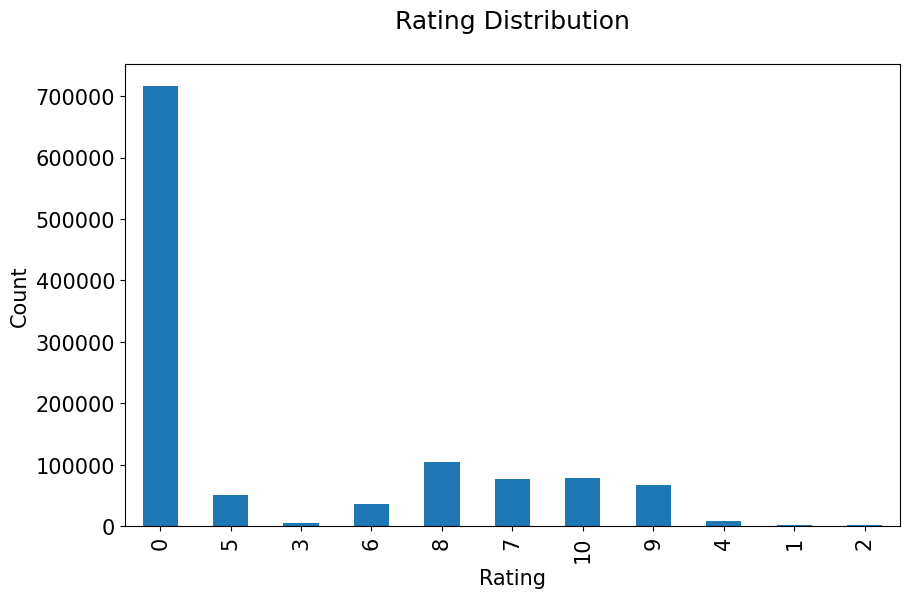

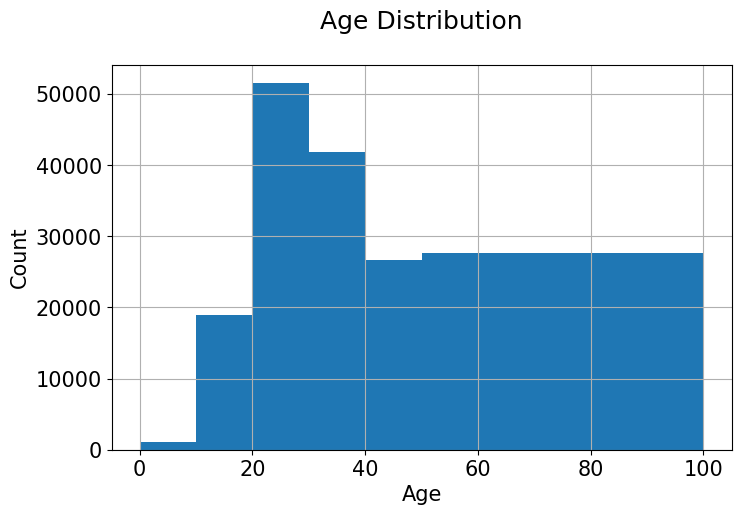



Top 10 Book Recommendations based on popularity:
35423: Wild Animus - 1419 ratings
29417: The Lovely Bones: A Novel - 861 ratings
27058: The Da Vinci Code - 638 ratings
4256: Bridget Jones's Diary - 618 ratings
29943: The Nanny Diaries: A Novel - 598 ratings
31171: The Secret Life of Bees - 574 ratings
852: A Painted House - 562 ratings
7899: Divine Secrets of the Ya-Ya Sisterhood: A Novel - 534 ratings
2234: Angels &amp; Demons - 503 ratings
15602: Life of Pi - 503 ratings


Recommendations for "The Da Vinci Code":
1: Angels &amp; Demons, with distance of 0.79
2: Digital Fortress : A Thriller, with distance of 0.86
3: Middlesex: A Novel, with distance of 0.87
4: The Secret Life of Bees, with distance of 0.88
5: The Lovely Bones: A Novel, with distance of 0.88
6: No Second  Chance, with distance of 0.89


In [34]:
# Example usage in the main execution block
if __name__ == "__main__":
    books, users, ratings = load_data()
    ratings, books, users = clean_data(ratings, books, users)
    check_missing_values(books, users, ratings)
    plot_rating_distribution(ratings)
    plot_age_distribution(users)
    ratings = filter_data(ratings)
    rating_with_totalRatingCount, book_ratingCount = prepare_data(ratings, books, users)
    rating_popular_book = filter_popular_books(rating_with_totalRatingCount)
    combined_pivot, model_knn = build_recommendation_model(rating_popular_book, users)

    # Get top 10 popular books based on rating count
    top_recommendations = get_top_recommendations(book_ratingCount, n_top=10)

    print()
    print()
    # Print top recommendations
    for rec in top_recommendations:
        print(rec)
    print()
    print()
    # Example usage for recommending similar books by title
    book_title = 'The Da Vinci Code'  # Replace with the desired book title
    recommendations = recommend_books_by_title(model_knn, combined_pivot, book_title)

    for rec in recommendations:
        print(rec)

    save_model(model_knn)
    model_knn = load_model()